### Linear Model Tree

### Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pytz
import time

import plotly.express as px
from scipy import stats

mpl.rcParams['figure.figsize'] = (18,12)
mpl.rcParams['axes.grid'] = False
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
sns.set()
sns.set_style('whitegrid')

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm

### Features of the data 

https://climate.weather.gc.ca/glossary_e.html#s <br>

$\textit{timestamp: }$ The date along with the time of the day the data was collected  <br>
$\textit{unixtime: }$ A system for describing a point in time <br>
$\textit{pressure_station: }$ The true pressure of the location recorded at the station in kilopascals (kPa) <br>
$\textit{pressure_sea: }$ The pressure at sea level in kilopascals (kPa) <br>
$\textit{wind_dir: }$ The direction of the wind <br>
$\textit{wind_dir_10: }$ Represented in 10s of degrees <br>
$\textit{wind_speed: }$ Speed of the motion of air in kilometres per hour (km/h) <br>
$\textit{wind_gust: }$ Sudden burst in wind speed in kilometres per hour (km/h) usually lasts for 20 seconds or under <br>
$\textit{relative_humidity: }$ Describes the amount of water vapour held in the air <br>
$\textit{dew_point: }$ The temperature in Celsius to which the air must be cooled before dew or frost begins to form  <br>
$\textit{temperature: }$ The current temperature of the air recorded at the station in Celsius <br>
$\textit{windchill: }$ Wind chill is an index to indicate how cold the weather feels to the average person <br>
$\textit{humidex: }$ Humidex is an index to indicate how hot or humid the weather feels to the average person <br>
$\textit{visibility: }$ Visibility in kilometres (km) is the distance at which objects of suitable size can be seen <br>
$\textit{health_index: }$ Scale designed to help you understand what the air quality around you means to your health <br>
$\textit{cloud_cover_4: }$ Measures the cloud cover <br>
$\textit{cloud_cover_8: }$ Measures the cloud cover <br>
$\textit{cloud_cover_10: }$ Measures the cloud cover <br>
$\textit{solar_radiation: }$ Solar radiation is the measurement of radiant energy from the sun <br>
$\textit{max_air_temp_pst1hr: }$ Maximum air temperature in the past one hour <br>
$\textit{min_air_temp_pst1hr: }$ Minimum air temperature in the past one hour <br>
$\textit{demand: }$ The electrical demand on hourly basis for the city of Toronto (MWhr) <br>

In [2]:
data = pd.read_csv('Data/Toronto_data.csv')
display(data.head())

timestamp    unixtime  pressure_station  pressure_sea wind_dir  \
0  2017-01-01 00  1483246800             98.67        100.79        W   
1  2017-01-01 01  1483250400             98.83        100.95        W   
2  2017-01-01 02  1483254000             98.95        101.08        W   
3  2017-01-01 03  1483257600             99.14        101.27        W   
4  2017-01-01 04  1483261200             99.28        101.41        W   

   wind_dir_10s  wind_speed  wind_gust  relative_humidity  dew_point  ...  \
0          26.0        35.0       45.0               69.0       -4.5  ...   
1          26.0        35.0        NaN               70.0       -4.5  ...   
2          26.0        32.0       43.0               67.0       -5.4  ...   
3          26.0        28.0        NaN               69.0       -5.1  ...   
4          26.0        27.0        NaN               69.0       -5.1  ...   

   visibility  health_index  cloud_cover_4  cloud_cover_8  cloud_cover_10  \
0     24100.0           NaN            NaN            7.0             NaN   
1     24100.0           NaN            NaN            7.0             NaN   
2     24100.0           2.3            NaN            7.0             NaN   
3     24100.0           2.3            NaN            7.0             NaN   
4     24100.0           2.2            NaN            7.0             NaN   

   solar_radiation  max_air_temp_pst1hr  min_air_temp_pst1hr  demand  \
0              NaN                  0.9                  0.3    5665   
1              NaN                  0.6                  0.2    5665   
2              NaN                  0.3                 -0.1    5665   
3              NaN                  0.0                 -0.2    5665   
4              NaN                 -0.1                 -0.3    5665   

   Ontario_demand  
0           13522  
1           13117  
2           12816  
3           12605  
4           12563  

[5 rows x 23 columns]

I am particularly interested in predicting the electrical demand data. Temperature of the surrounding air, for obvious reasons, affects the electrical demand. We can drop the remaining columns and use the date_time_local as a datetime object to index the data frame.

In [3]:
data.drop(['unixtime','pressure_station','pressure_sea','wind_dir', 'wind_dir_10s', 'wind_gust','dew_point',
           'windchill','visibility', 'health_index', 'cloud_cover_4', 'cloud_cover_10', 'solar_radiation',
            'humidex','max_air_temp_pst1hr','min_air_temp_pst1hr','relative_humidity','wind_speed','cloud_cover_8']
          ,axis=1,inplace=True)

display(data.head())
display(data.shape)

timestamp  temperature  demand  Ontario_demand
0  2017-01-01 00          0.5    5665           13522
1  2017-01-01 01          0.3    5665           13117
2  2017-01-01 02          0.0    5665           12816
3  2017-01-01 03         -0.1    5665           12605
4  2017-01-01 04         -0.1    5665           12563

(36072, 4)

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

data_noindex = data.copy()
data = data.set_index('timestamp')

year = '2018'
data = data.loc[year:]

display(data.head())

temperature  demand  Ontario_demand
timestamp                                               
2018-01-01 00:00:00        -19.5    5340           16627
2018-01-01 01:00:00        -21.7    5211           16084
2018-01-01 02:00:00        -19.3    5096           15866
2018-01-01 03:00:00        -20.3    4987           15725
2018-01-01 04:00:00        -19.9    4926           15470

### Handling missing values

Let's check the number of missing data points in the temperature and demand data. Looks like IESO has been doing a good job maintaing their demand data. They seem to have adjusted for missing data already. And there are only 7 missing data points in the temperature data too. We will fix these shortly.

In [5]:
display(pd.DataFrame({'Missing Values':data.isna().sum(),'Percentage':data.isna().sum()*100/data.shape[0]}))

Missing Values  Percentage
temperature                  5    0.018307
demand                       0    0.000000
Ontario_demand               0    0.000000

Let us take a look at the missing values in the temperature and fix them. We can observe that the missing values are not continuous and therefore, we could use forward fill to fill in these missing data points.

In [6]:
display(data.query('temperature != temperature'))

temperature  demand  Ontario_demand
timestamp                                               
2018-07-07 01:00:00          NaN    4614           12627
2018-07-07 02:00:00          NaN    4389           12064
2018-09-09 04:00:00          NaN    3705           10809
2019-05-13 19:00:00          NaN    6040           16248
2020-06-11 00:00:00          NaN    5528           14341

In [7]:
data['temperature'] = data['temperature'].fillna(method='ffill')
display(pd.DataFrame({'Missing Values':data.isna().sum(),'Percentage':data.isna().sum()*100/data.shape[0]}))

Missing Values  Percentage
temperature                  0         0.0
demand                       0         0.0
Ontario_demand               0         0.0

### Defining relevant Functions

We split the data set into various categories based on the domain knowledge of factors affecting the electrical demand

$\textit{Temperature: }$ Based on the above analysis we split it into "Hot" (>15 degrees) and "NotHot" (<15 degrees) <br>
$\textit{Time of the day: }$ Split into "AwakeHours" (7am to 10pm) and "SleepHours" (10pm to 7am) <br>
$\textit{Type of the day: }$ Split into "Weekend" and "Weekday" <br> 
$\textit{Pandemic effects: }$ We can look at the information available at https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Ontario#Lifting_of_restrictions_after_the_first_wave to look at different stages of lockdown.

In [8]:
def temp_(x):
    """
    Divides the dataset into two categories based on the temperature
    """
    if x > 15:
        return 'Hot'
    else:
        return 'NotHot'

def peak_(x):
    """
    Divides the dataset into two categories based on the hour of the day
    """
    if x >= 7 and x <= 22:
        return 'AwakeHours'
    else: 
        return 'SleepHours'
    
def weekday_(x):
    """
    Divides the dataset into two categories based on the day of the week
    """
    if x >= 5:
        return 'Weekend'
    else:
        return 'Weekday'
    
def pandemic_(x):
    """
    Divides the dataset into multiple categories based on the type of lockdown imposed
    """
    if x >= datetime.date(2020,12,21):
        return 'FullLockdown'
    elif x >= datetime.date(2020,10,10):
        return 'ModifiedStageTwo'
    elif x >= datetime.date(2020,8,12):
        return 'StageThree'
    elif x >= datetime.date(2020,6,24):
        return 'StageTwo'
    elif x >= datetime.date(2020,5,20):
        return 'StageOne'
    elif x >= datetime.date(2020,3,17):
        return 'FullLockdown'  
    else:
        return 'NormalDay'
    
def dayofweek_(x):
    """
    Divides the dataset into seven categories based on the day of the week
    """
    if x == 0:
        return 'Monday'
    elif x == 1:
        return 'Tuesday'
    elif x == 2:
        return 'Wednesday'
    elif x == 3:
        return 'Thursday'
    elif x == 4:
        return 'Friday'
    elif x == 5:
        return 'Saturday'
    elif x == 6:
        return 'Sunday'

est = pytz.timezone('US/Eastern')
def dst_index(x):
    """
    Divides the dataset into two categories based on whether or not daylight savings is in place
    """
    if est.localize(x).dst().seconds == 0:
        return "NoDST"
    else:
        return "DST"

Extracting several relevant features from the data

In [9]:
data['year'] = data.index.year
data['month'] = data.index.month
data['dayofweek'] = data.index.dayofweek
data['day'] = data.index.day
data['hour'] = data.index.hour
data['temp_index'] = data['temperature'].apply(temp_)
data['hour_index'] = data['hour'].apply(peak_)
data['week_index'] = data['dayofweek'].apply(weekday_)
data['dst_index'] = [dst_index(x) for x in data.reset_index()['timestamp']]
display(data.head())

temperature  demand  Ontario_demand  year  month  \
timestamp                                                               
2018-01-01 00:00:00        -19.5    5340           16627  2018      1   
2018-01-01 01:00:00        -21.7    5211           16084  2018      1   
2018-01-01 02:00:00        -19.3    5096           15866  2018      1   
2018-01-01 03:00:00        -20.3    4987           15725  2018      1   
2018-01-01 04:00:00        -19.9    4926           15470  2018      1   

                     dayofweek  day  hour temp_index  hour_index week_index  \
timestamp                                                                     
2018-01-01 00:00:00          0    1     0     NotHot  SleepHours    Weekday   
2018-01-01 01:00:00          0    1     1     NotHot  SleepHours    Weekday   
2018-01-01 02:00:00          0    1     2     NotHot  SleepHours    Weekday   
2018-01-01 03:00:00          0    1     3     NotHot  SleepHours    Weekday   
2018-01-01 04:00:00          0    1     4     NotHot  SleepHours    Weekday   

                    dst_index  
timestamp                      
2018-01-01 00:00:00     NoDST  
2018-01-01 01:00:00     NoDST  
2018-01-01 02:00:00     NoDST  
2018-01-01 03:00:00     NoDST  
2018-01-01 04:00:00     NoDST

### Holidays

Incorporating some of the public holidays and treating them as weekend

In [10]:
for year in list(data['year'].unique()):
    try:
        data.loc[str(year) + '-1-1','week_index'] = 'Weekend'
        data.loc[str(year) + '-7-1','week_index'] = 'Weekend'
        data.loc[str(year) + '-12-25','week_index'] = 'Weekend'
        data.loc[str(year) + '-12-26','week_index'] = 'Weekend'
    except:
        continue

### Exploratory Analysis

The other notebook "Analysis_ElectricityDemand" has a detailed analysis of various factors and its effects. In this we just revisit some of them quickly and plot them. It is a fair assumption to make that the electricity demand is strongly dependent on the temperature. In the plot below, we can see the relation between temperature and demand for various cases.

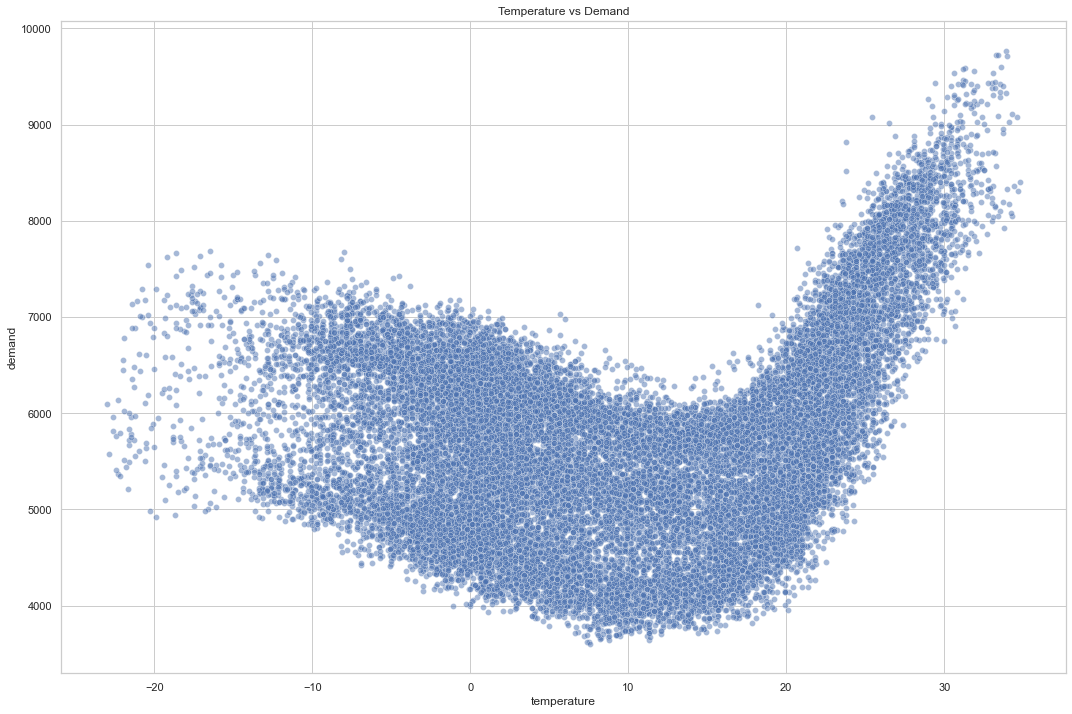

In [11]:
sns.scatterplot(x='temperature',y='demand',data=data,palette="mako", alpha = 0.5);
plt.title('Temperature vs Demand');

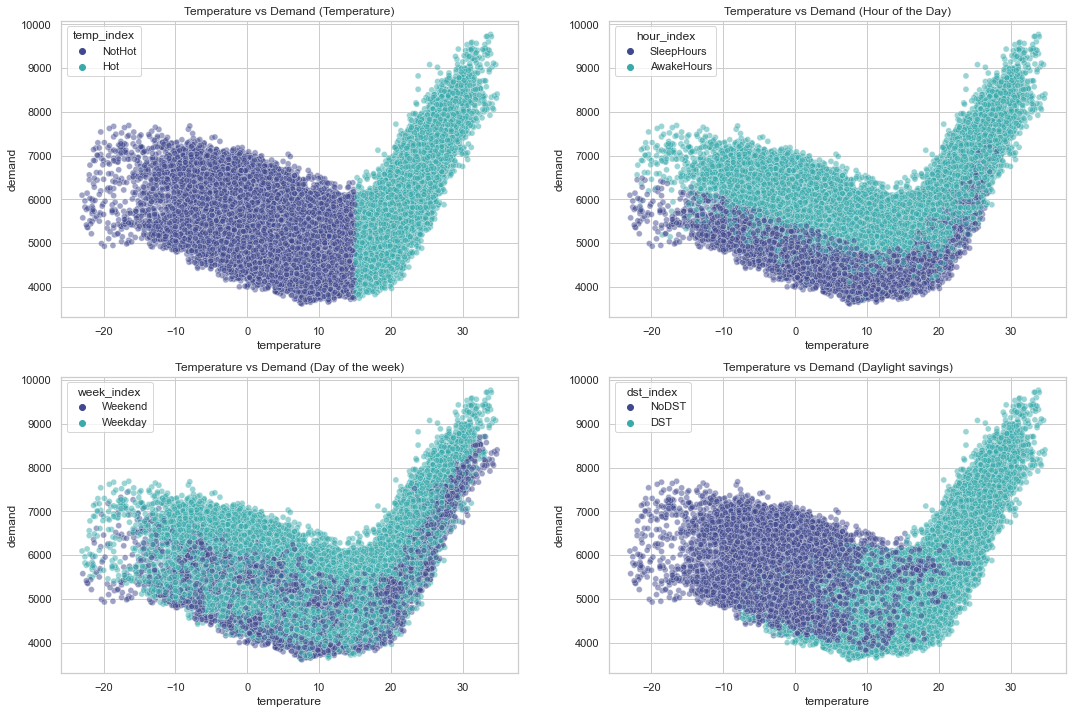

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.scatterplot(x='temperature',y='demand',hue='temp_index',data=data,ax=axes[0,0],palette="mako", alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand (Temperature)');
sns.scatterplot(x='temperature',y='demand',hue='hour_index',data=data,ax=axes[0,1],palette="mako", alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand (Hour of the Day)');
sns.scatterplot(x='temperature',y='demand',hue='week_index',data=data,ax=axes[1,0],palette="mako", alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand (Day of the week)');
sns.scatterplot(x='temperature',y='demand',hue='dst_index',data=data,ax=axes[1,1],palette="mako", alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand (Daylight savings)');

### Linear Model Tree

As discussed in "Analysis_ElectricityDemand", we can see a positive relationship in the Hot category and a negative relationship in the NotHot category. We can further divide it into two categories based on whether it is awake hours or sleep hours. This way we have four categories that have individual linear relationship.

In [13]:
def sections(x,y):
    """
    Divides the dataset into four sections as discussed above
    """
    if x == 'AwakeHours' and y == 'Hot':
        return 'Section1'
    elif x == 'AwakeHours' and y == 'NotHot':
        return 'Section2'
    elif x == 'SleepHours' and y == 'NotHot':
        return 'Section3'
    elif x == 'SleepHours' and y == 'Hot':
        return 'Section4'

In [14]:
data['sections'] = data.apply(lambda x: sections(x['hour_index'],x['temp_index']), axis=1)
display(data.head())

temperature  demand  Ontario_demand  year  month  \
timestamp                                                               
2018-01-01 00:00:00        -19.5    5340           16627  2018      1   
2018-01-01 01:00:00        -21.7    5211           16084  2018      1   
2018-01-01 02:00:00        -19.3    5096           15866  2018      1   
2018-01-01 03:00:00        -20.3    4987           15725  2018      1   
2018-01-01 04:00:00        -19.9    4926           15470  2018      1   

                     dayofweek  day  hour temp_index  hour_index week_index  \
timestamp                                                                     
2018-01-01 00:00:00          0    1     0     NotHot  SleepHours    Weekend   
2018-01-01 01:00:00          0    1     1     NotHot  SleepHours    Weekend   
2018-01-01 02:00:00          0    1     2     NotHot  SleepHours    Weekend   
2018-01-01 03:00:00          0    1     3     NotHot  SleepHours    Weekend   
2018-01-01 04:00:00          0    1     4     NotHot  SleepHours    Weekend   

                    dst_index  sections  
timestamp                                
2018-01-01 00:00:00     NoDST  Section3  
2018-01-01 01:00:00     NoDST  Section3  
2018-01-01 02:00:00     NoDST  Section3  
2018-01-01 03:00:00     NoDST  Section3  
2018-01-01 04:00:00     NoDST  Section3

In each of the sections, we can now spot a linear relationship and the corresponding pearson coefficients are shown below.

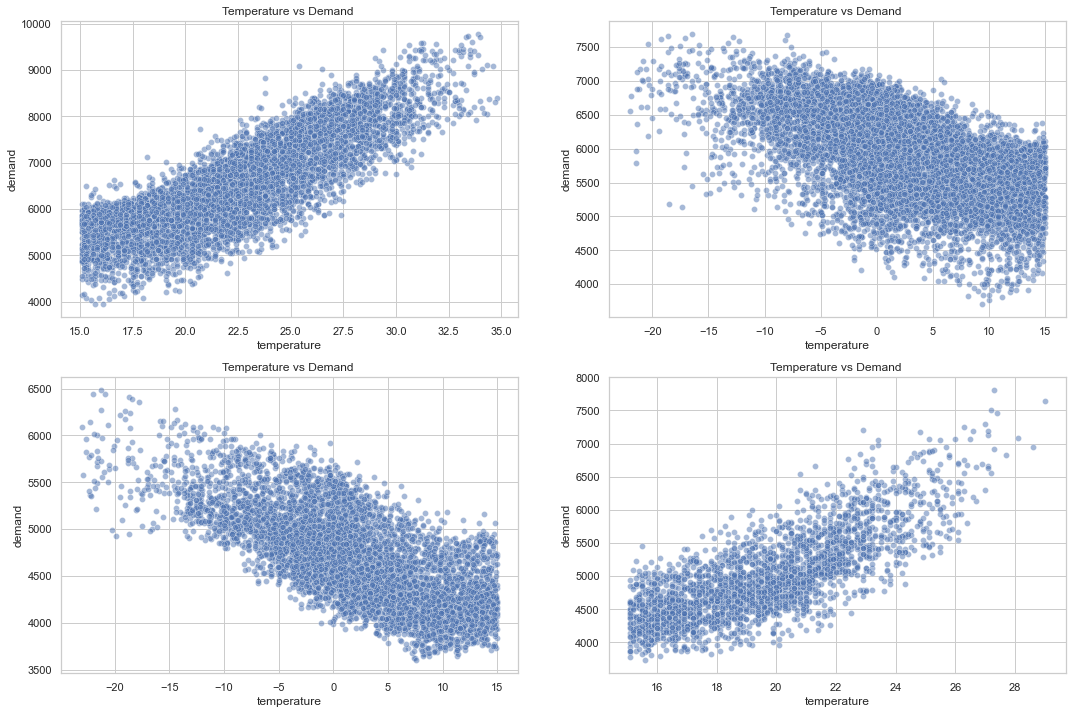

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section1"'),ax=axes[0,0], alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section2"'),ax=axes[0,1], alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section3"'),ax=axes[1,0], alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section4"'),ax=axes[1,1], alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand ');

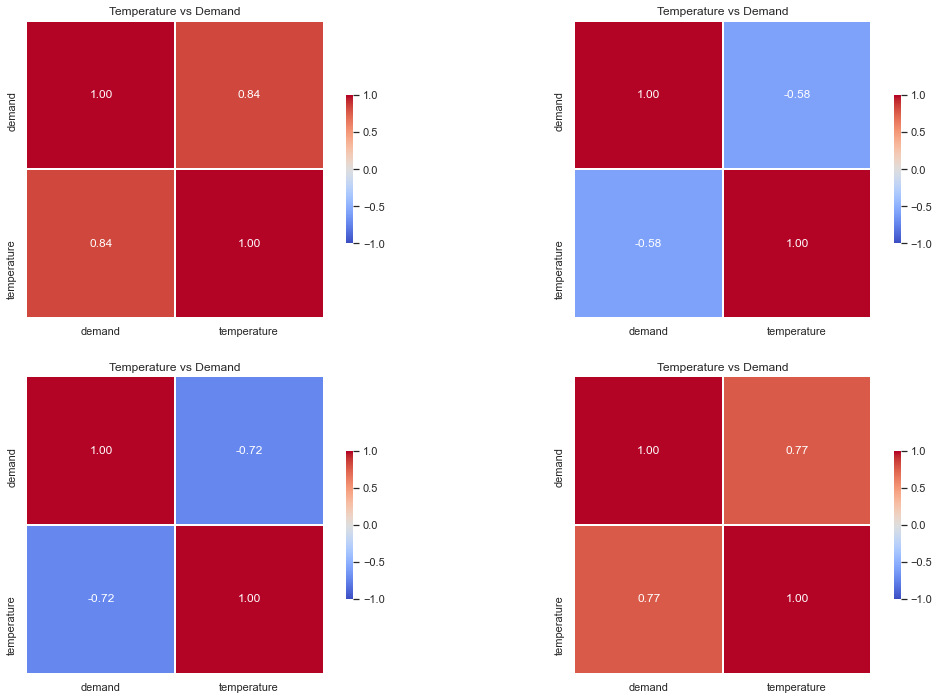

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.heatmap(data.query('sections == "Section1"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,0]);
axes[0,0].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections == "Section2"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,1]);
axes[0,1].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections == "Section3"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,0]);
axes[1,0].set_title('Temperature vs Demand');
sns.heatmap(data.query('sections == "Section4"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.5}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,1]);
axes[1,1].set_title('Temperature vs Demand');

We can now split it further based on whether it is a weekend or weekday and we are going to end up with eight sections.

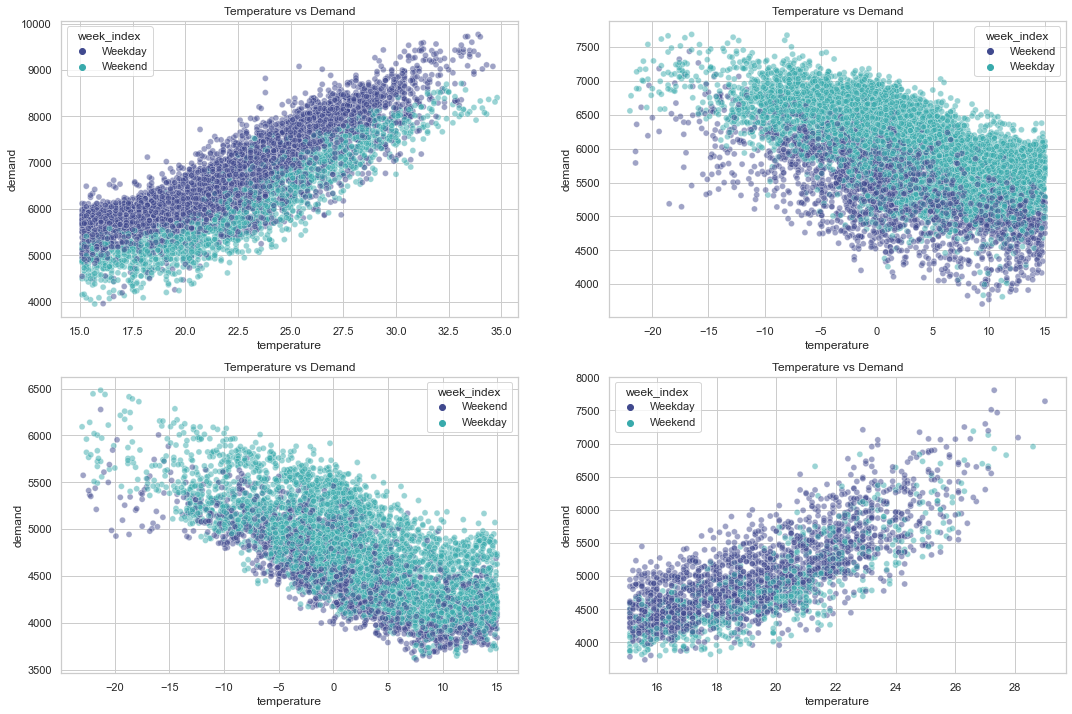

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2)

sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section1"'),hue='week_index',ax=axes[0,0],palette="mako", alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section2"'),hue='week_index',ax=axes[0,1],palette="mako", alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section3"'),hue='week_index',ax=axes[1,0],palette="mako", alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections == "Section4"'),hue='week_index',ax=axes[1,1],palette="mako", alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand');

In [18]:
def sections_1(x,y):
    """
    Divides the dataset into eight sections as shown above
    """
    if x == 'Section1' and y == 'Weekend':
        return 'Section1'
    elif x == 'Section1' and y == 'Weekday':
        return 'Section2'
    elif x == 'Section2' and y == 'Weekend':
        return 'Section3'
    elif x == 'Section2' and y == 'Weekday':
        return 'Section4'
    elif x == 'Section3' and y == 'Weekend':
        return 'Section5'
    elif x == 'Section3' and y == 'Weekday':
        return 'Section6'
    elif x == 'Section4' and y == 'Weekend':
        return 'Section7'
    elif x == 'Section4' and y == 'Weekday':
        return 'Section8'

In [19]:
data['sections_1'] = data.apply(lambda x: sections_1(x['sections'],x['week_index']), axis=1)
display(data.head())

temperature  demand  Ontario_demand  year  month  \
timestamp                                                               
2018-01-01 00:00:00        -19.5    5340           16627  2018      1   
2018-01-01 01:00:00        -21.7    5211           16084  2018      1   
2018-01-01 02:00:00        -19.3    5096           15866  2018      1   
2018-01-01 03:00:00        -20.3    4987           15725  2018      1   
2018-01-01 04:00:00        -19.9    4926           15470  2018      1   

                     dayofweek  day  hour temp_index  hour_index week_index  \
timestamp                                                                     
2018-01-01 00:00:00          0    1     0     NotHot  SleepHours    Weekend   
2018-01-01 01:00:00          0    1     1     NotHot  SleepHours    Weekend   
2018-01-01 02:00:00          0    1     2     NotHot  SleepHours    Weekend   
2018-01-01 03:00:00          0    1     3     NotHot  SleepHours    Weekend   
2018-01-01 04:00:00          0    1     4     NotHot  SleepHours    Weekend   

                    dst_index  sections sections_1  
timestamp                                           
2018-01-01 00:00:00     NoDST  Section3   Section5  
2018-01-01 01:00:00     NoDST  Section3   Section5  
2018-01-01 02:00:00     NoDST  Section3   Section5  
2018-01-01 03:00:00     NoDST  Section3   Section5  
2018-01-01 04:00:00     NoDST  Section3   Section5

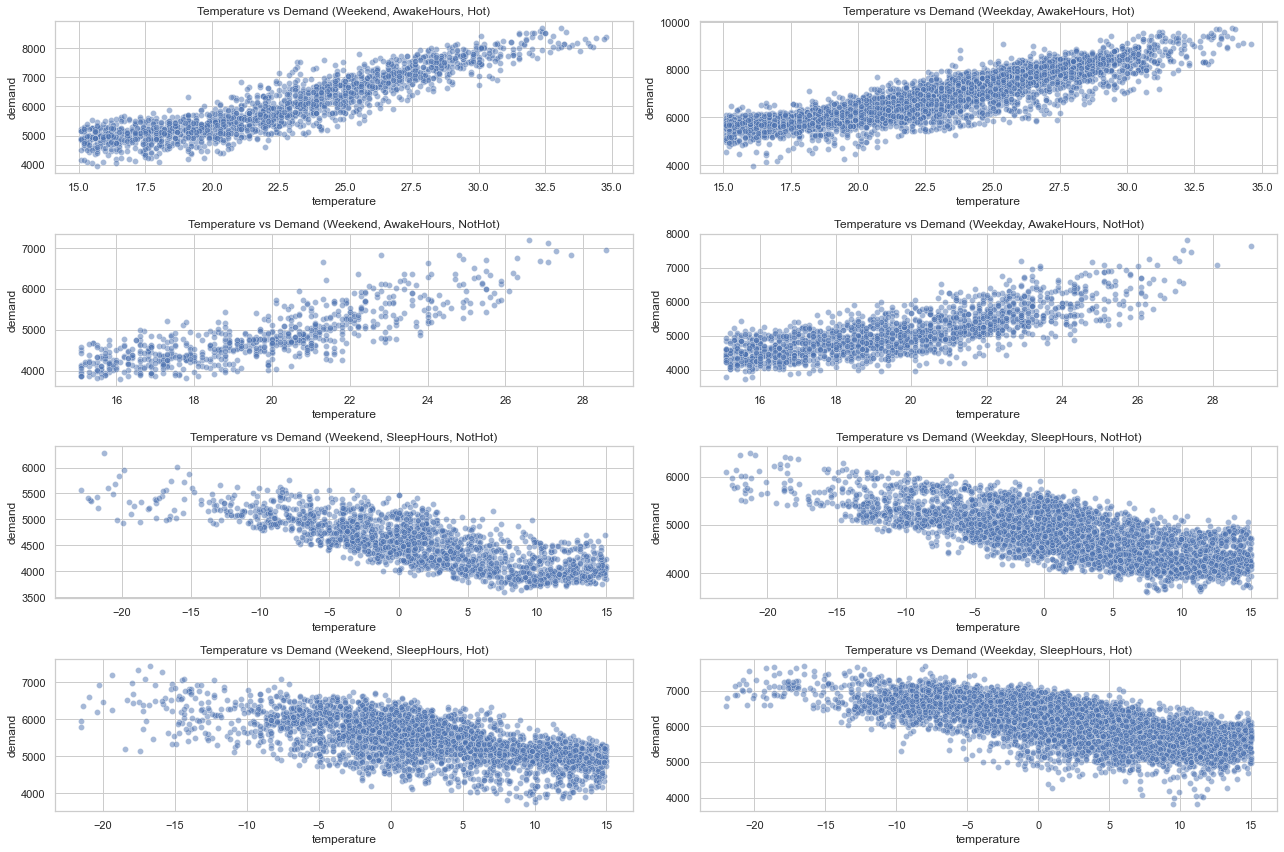

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=2)

sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section1"'),ax=axes[0,0], alpha = 0.5);
axes[0,0].set_title('Temperature vs Demand (Weekend, AwakeHours, Hot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section2"'),ax=axes[0,1], alpha = 0.5);
axes[0,1].set_title('Temperature vs Demand (Weekday, AwakeHours, Hot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section3"'),ax=axes[3,0], alpha = 0.5);
axes[1,0].set_title('Temperature vs Demand (Weekend, AwakeHours, NotHot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section4"'),ax=axes[3,1], alpha = 0.5);
axes[1,1].set_title('Temperature vs Demand (Weekday, AwakeHours, NotHot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section5"'),ax=axes[2,0], alpha = 0.5);
axes[2,0].set_title('Temperature vs Demand (Weekend, SleepHours, NotHot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section6"'),ax=axes[2,1], alpha = 0.5);
axes[2,1].set_title('Temperature vs Demand (Weekday, SleepHours, NotHot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section7"'),ax=axes[1,0], alpha = 0.5);
axes[3,0].set_title('Temperature vs Demand (Weekend, SleepHours, Hot)');
sns.scatterplot(x='temperature',y='demand',data=data.query('sections_1 == "Section8"'),ax=axes[1,1], alpha = 0.5);
axes[3,1].set_title('Temperature vs Demand (Weekday, SleepHours, Hot)');

fig.tight_layout();

We can now see a further stronger linear relationship in each of these sections and the pearson coefficients are shown below. 

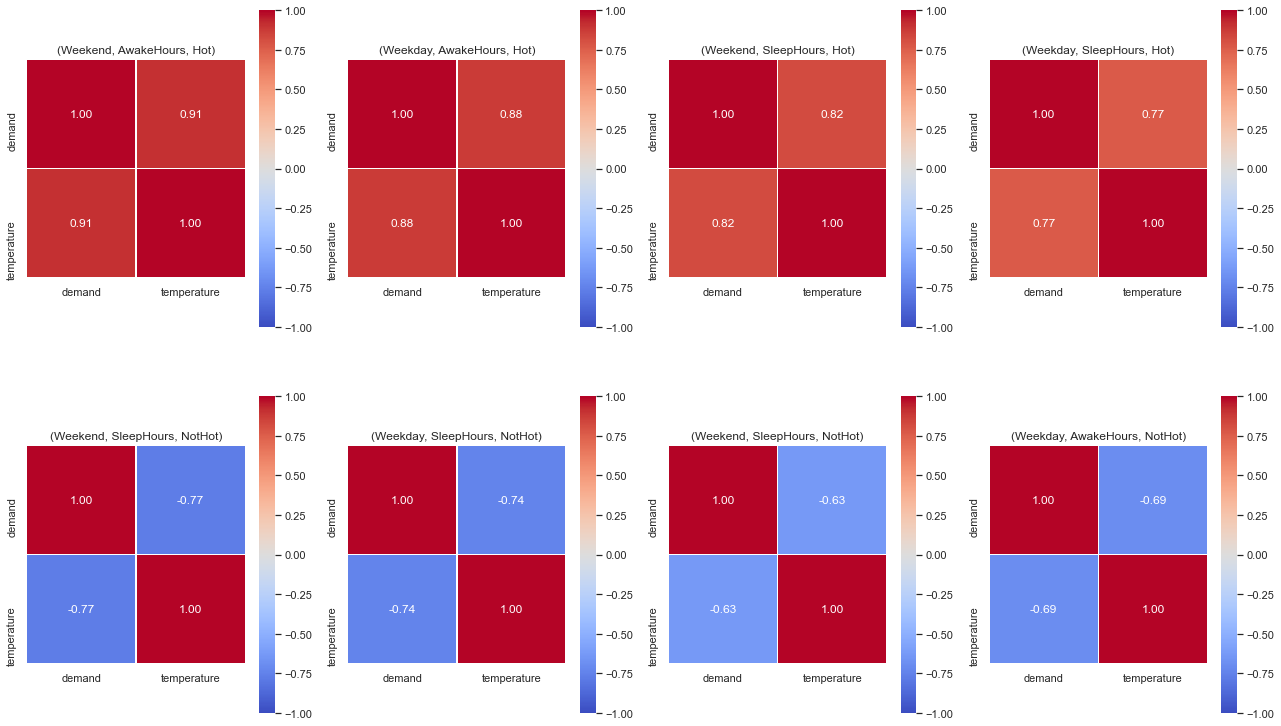

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=4)

sns.heatmap(data.query('sections_1 == "Section1"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,0]);
axes[0,0].set_title('(Weekend, AwakeHours, Hot)');
sns.heatmap(data.query('sections_1 == "Section2"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,1]);
axes[0,1].set_title('(Weekday, AwakeHours, Hot)');
sns.heatmap(data.query('sections_1 == "Section3"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,2]);
axes[1,2].set_title('(Weekend, SleepHours, NotHot)');
sns.heatmap(data.query('sections_1 == "Section4"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,3]);
axes[1,3].set_title('(Weekday, AwakeHours, NotHot)');
sns.heatmap(data.query('sections_1 == "Section5"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,0]);
axes[1,0].set_title('(Weekend, SleepHours, NotHot)');
sns.heatmap(data.query('sections_1 == "Section6"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1,1]);
axes[1,1].set_title('(Weekday, SleepHours, NotHot)');
sns.heatmap(data.query('sections_1 == "Section7"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,2]);
axes[0,2].set_title('(Weekend, SleepHours, Hot)');
sns.heatmap(data.query('sections_1 == "Section8"')[['demand','temperature']].corr(method='pearson'), vmax = 1, vmin=-1, center=0,
               square=True, linewidth=0.5, cbar_kws={"shrink":0.7}, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0,3]);
axes[0,3].set_title('(Weekday, SleepHours, Hot)');

fig.tight_layout();

We can now split the dataset into a training set and a forecast set. We can use the data points from 2017 to 2020, to predict the first 18 days (=18$*$24 points). 

In [22]:
pred_start = datetime.datetime.strftime(data.reset_index()['timestamp'].iloc[-1],'%Y-%m-%d')
train_end = datetime.datetime.strftime(data.reset_index()['timestamp'].iloc[-1],'%Y-%m-%d')[:8] + str(int(datetime.datetime.strftime(data.reset_index()['timestamp'].iloc[-1],'%Y-%m-%d')[8:])-1)
pred_day = data.loc[pred_start:]
train_days = data.loc['2017':train_end]

In [23]:
def predict(data,group_by,ridge_coef):
    """
    Given, a data point, the groups by which we split and the regression coefficients, this function returns a prediction
    """
    group = tuple(data[group_by])
    idx = groupby_list.index(group)
    (inter,slope) = ridge_coef[idx]
    return inter + slope*data['temperature']

def RMSE_error(data,forecast):
    """
    This function gives the RMSE for the forecats
    """
    return np.sqrt((1/data.shape[0])*np.sum(np.square(data-forecast)))

def baseline_model(data_1,data,i):
    """
    Defines a baseline model for 2021 forecast, based on 2020 datapoints
    """
    return data.loc['2020'].iloc[i]['demand']

def baseline_model_1(data_1,data,i):
    """
    Defines a baseline model for 2021 forecast, based on 2020 datapoints shifted to match the weekends
    """
    if i == 0:
        return data.loc['2020'].iloc[i]['demand']
    else:
        return data.loc['2020'].iloc[i+48]['demand']


def pred_interval(prediction,test_data,test_predictions,alpha=0.95):
    """
    Obtain the prediction interval for each of the prediction
    Input: single prediction, entire test data, test set predictions
    Output: Prediction intervals and the actual prediction
    """
    y_test = test_data['demand']
    test_predictions = np.array(test_predictions)
    err = np.sum(np.square((y_test - test_predictions)))
    std = np.sqrt((1 / (y_test.shape[0] - 2)) * err)
    z = stats.norm.ppf(1 - (1-alpha)/2)
    interval = z*std
    
    return [float(prediction-interval),float(prediction),float(prediction+interval)]

### Baseline Model

In [24]:
demand_hat = []
for i in range(pred_day.shape[0]):
    demand_hat.append(baseline_model(pred_day.iloc[i],data,i))
print(f"The RMSE is: {RMSE_error(pred_day['demand'],demand_hat)}")
display(RMSE_error(pred_day['demand'],demand_hat)*100/pred_day['demand'].mean())

The RMSE is: 1195.021582789756


19.487092403673223

In [25]:
prediction_interval = []
for i in range(pred_day.shape[0]):
    prediction_interval.append(pred_interval(demand_hat[i],pred_day,demand_hat))
pred_int = pd.DataFrame(prediction_interval,columns=['Lower','Actual','Upper'])
display(pred_int.head())

Lower  Actual        Upper
0  2271.652655  4718.0  7164.347345
1  2124.652655  4571.0  7017.347345
2  1996.652655  4443.0  6889.347345
3  1909.652655  4356.0  6802.347345
4  1870.652655  4317.0  6763.347345

In [26]:
df = pd.DataFrame({'time':pred_day.index,'predictions':demand_hat})

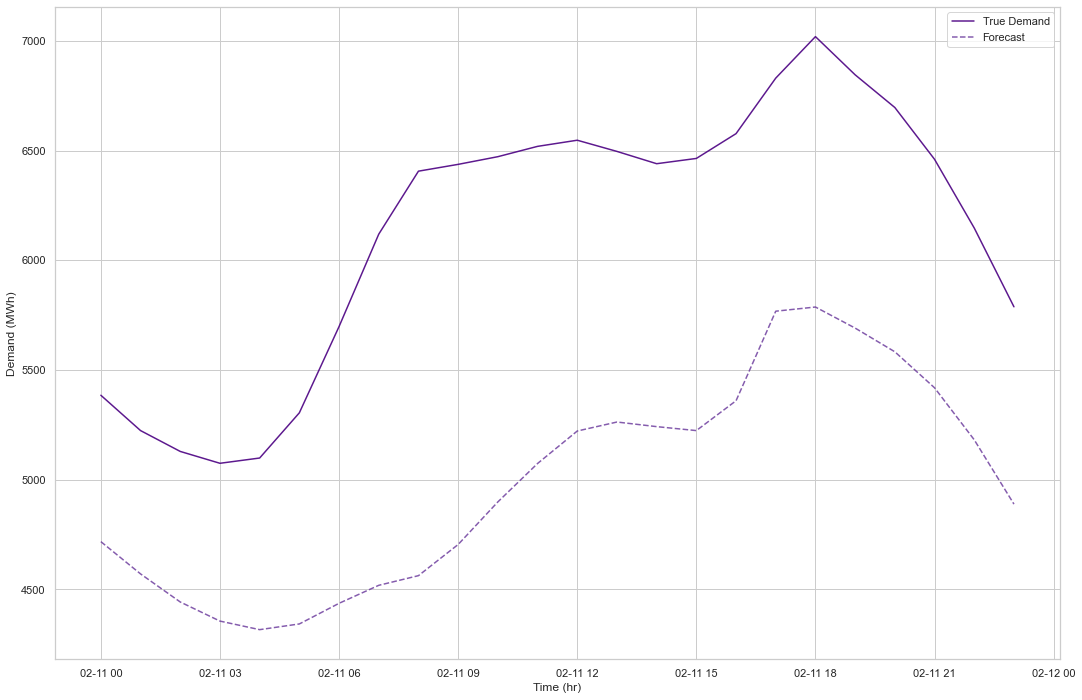

In [27]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

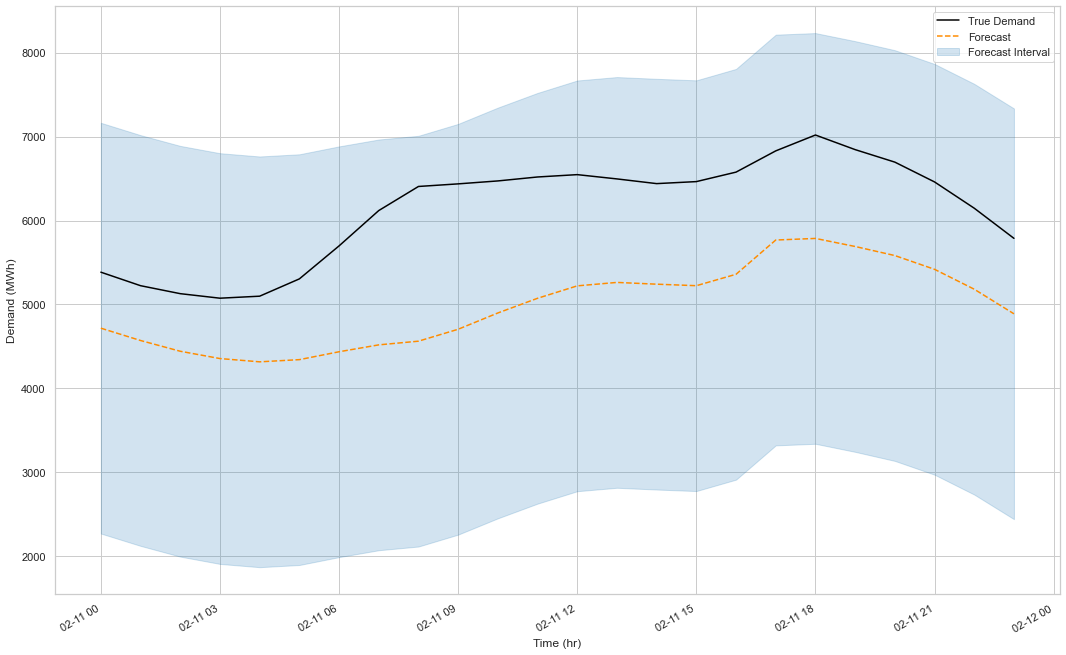

In [28]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int.set_index(pred_day.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int['Lower'],pred_int['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

### Baseline model 1

In [29]:
demand_hat_0 = []
for i in range(pred_day.shape[0]):
    demand_hat_0.append(baseline_model_1(pred_day.iloc[i],data,i))
print(f"The RMSE is: {RMSE_error(pred_day['demand'],demand_hat_0)}")

The RMSE is: 711.3138957825394


In [30]:
display(RMSE_error(pred_day['demand'],demand_hat_0)*100/pred_day['demand'].mean())

11.59932156436192

In [31]:
prediction_interval_0 = []
for i in range(pred_day.shape[0]):
    prediction_interval_0.append(pred_interval(demand_hat_0[i],pred_day,demand_hat_0))
pred_int_0 = pd.DataFrame(prediction_interval_0,columns=['Lower','Actual','Upper'])
display(pred_int_0.head())

Lower  Actual        Upper
0  3261.858215  4718.0  6174.141785
1  3059.858215  4516.0  5972.141785
2  2924.858215  4381.0  5837.141785
3  2859.858215  4316.0  5772.141785
4  2882.858215  4339.0  5795.141785

In [32]:
df_0 = pd.DataFrame({'time':pred_day.index,'predictions':demand_hat_0})

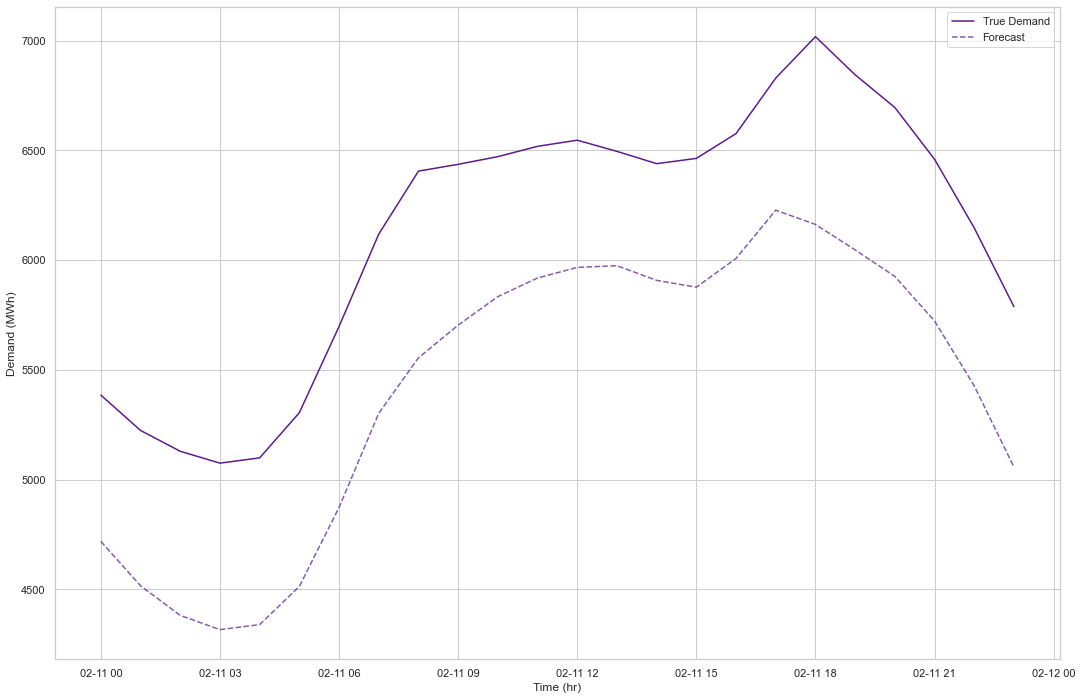

In [33]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df_0,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

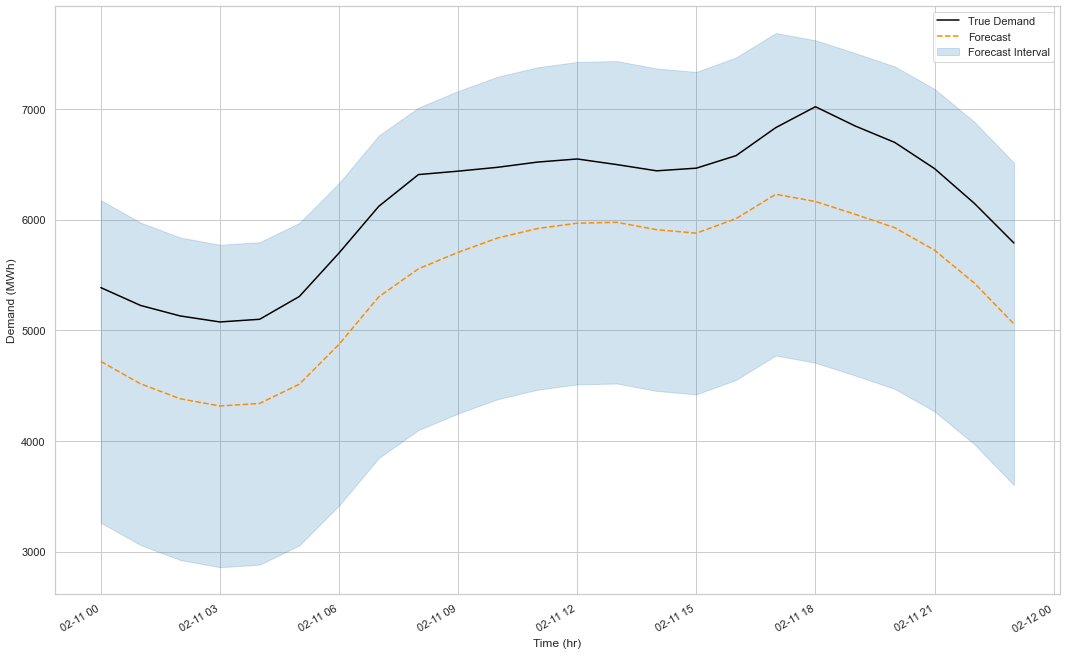

In [34]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_0.set_index(pred_day.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int_0['Lower'],pred_int_0['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [35]:
def Ridge_error(data):
    """
    Based on the provided data, this function returns the training error while performing ridge regression
    """
    x = data['temperature'].values.reshape(-1,1)
    y = data['demand'].values.reshape(-1,1)
    model = Ridge().fit(x,y)
    train_error = np.sqrt((1/y.shape[0])*np.sum(np.square(np.squeeze(model.predict(x)) - y.T)))
    return (round(float(train_error),3))

def Ridge_model(data):
    """
    Based on the provided data, this function returns the 
    coefficients of the ridge regression.
    
    input: the training data
    output: ridge regression coefficients
    
    """
    data = data.sample(frac=1,random_state=42)
    x = data['temperature'].values.reshape(-1,1)
    y = data['demand'].values.reshape(-1,1)
    model = Ridge().fit(x, y)
    return (round(float(model.intercept_),3),round(float(model.coef_),3))   

### Model with two categories 
#### ("AwakeHours" and  "SleepHours")
Here, we train a linear model with two categories for each of the eight sections

In [36]:
num = train_days['temp_index'].nunique()*train_days['hour_index'].nunique()*train_days['week_index'].nunique()

Train_error = np.zeros((num,1))

for i in range(1,num+1):
    train = train_days.groupby('sections_1').apply(Ridge_error)['Section'+str(i)]
    Train_error[i-1] = train

print(Train_error.mean())

386.78262500000005


The coefficients of regression in each of the category is shown below.

In [37]:
start = time.time()

ridge_coef_1= train_days.groupby(['temp_index','hour_index','week_index']).apply(Ridge_model)
display(pd.DataFrame(ridge_coef_1,columns=['Regression Coefficients (Intercept,Slope)']))

end = time.time()
time_lm8 = end - start
print(time_lm8)

Regression Coefficients (Intercept,Slope)
temp_index hour_index week_index                                          
Hot        AwakeHours Weekday                           (2208.73, 203.186)
                      Weekend                          (1315.382, 208.581)
           SleepHours Weekday                           (1641.215, 175.37)
                      Weekend                          (1068.905, 190.516)
NotHot     AwakeHours Weekday                          (6244.162, -53.137)
                      Weekend                          (5588.993, -52.024)
           SleepHours Weekday                          (4870.307, -49.074)
                      Weekend                          (4599.098, -47.935)

0.046864986419677734


In [38]:
groupby_list = list(data.groupby(['temp_index','hour_index','week_index']).groups.keys())

In [39]:
demand_hat_1 = []
for i in range(pred_day.shape[0]):
    demand_hat_1.append(predict(pred_day.iloc[i],['temp_index','hour_index','week_index'],ridge_coef_1))
print(f"The RMSE is: {RMSE_error(pred_day['demand'],demand_hat_1)}")

The RMSE is: 265.61539932626744


In [40]:
display(RMSE_error(pred_day['demand'],demand_hat_1)*100/pred_day['demand'].mean())

4.331362633992009

In [41]:
prediction_interval_1 = []
for i in range(pred_day.shape[0]):
    prediction_interval_1.append(pred_interval(demand_hat_1[i],pred_day,demand_hat_1))
pred_int_1 = pd.DataFrame(prediction_interval_1,columns=['Lower','Actual','Upper'])
display(pred_int_1.head())

Lower     Actual        Upper
0  4724.060968  5267.8064  5811.551832
1  4714.246168  5257.9916  5801.737032
2  4719.153568  5262.8990  5806.644432
3  4728.968368  5272.7138  5816.459232
4  4753.505368  5297.2508  5840.996232

In [42]:
df_1 = pd.DataFrame({'time':pred_day.index,'predictions':demand_hat_1})

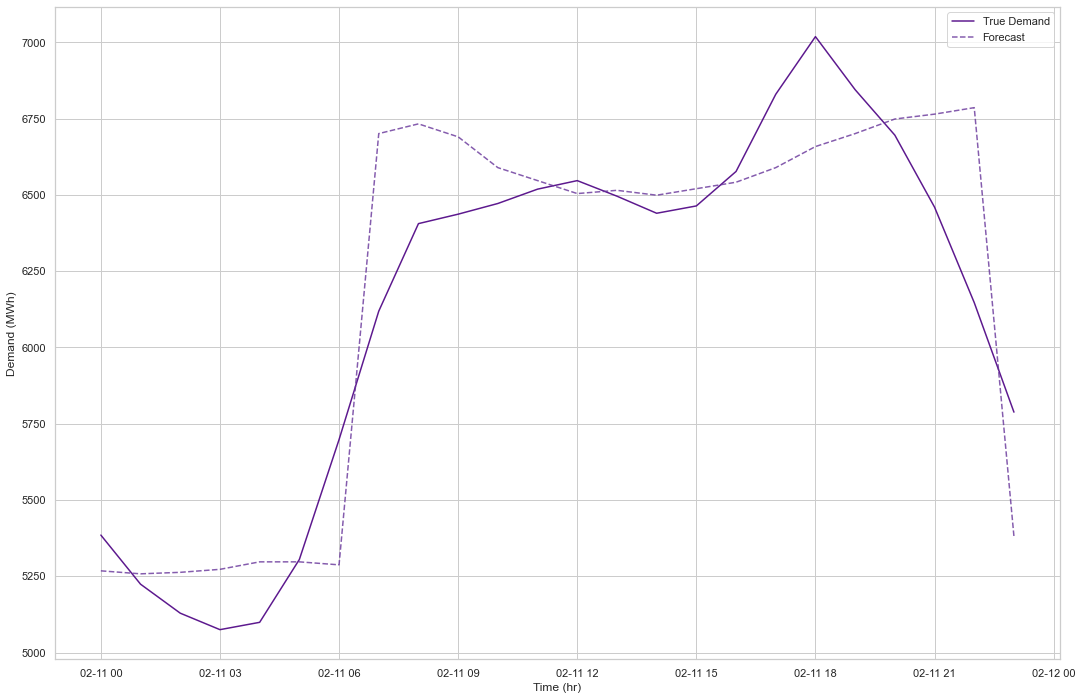

In [43]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df_1,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

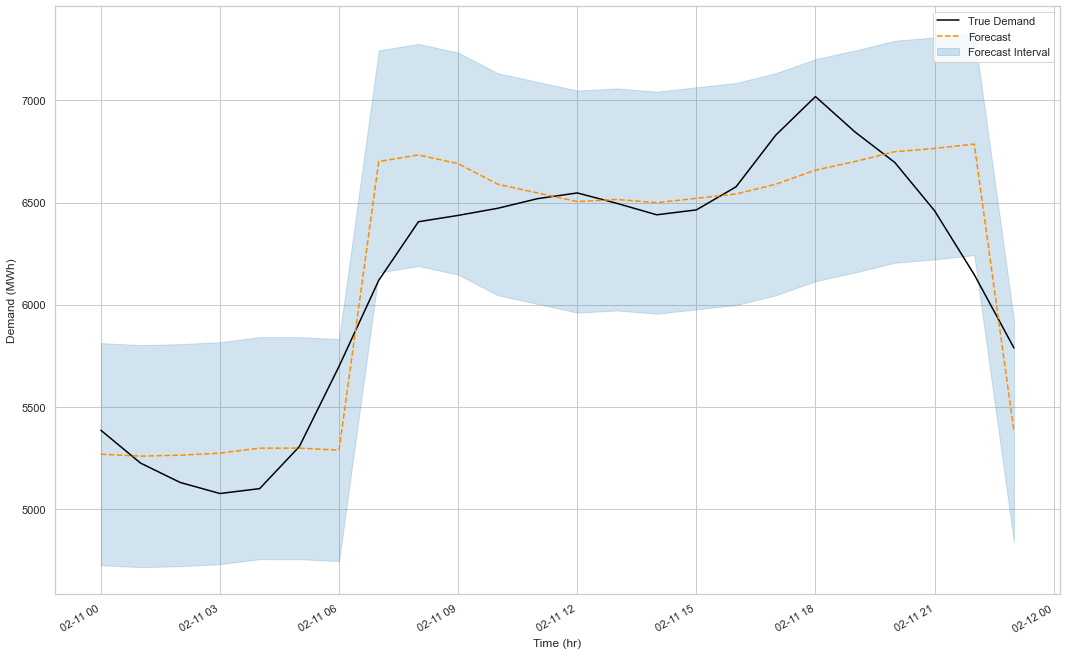

In [44]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_1.set_index(pred_day.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int_1['Lower'],pred_int_1['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

### Model with five categories 
#### ("EarlyMorning", "Morning", "Noon", "Evening" and "Night")
Here, we train a linear model with five categories. Therefore, we would have 2$*$2$*$5 = 20 sections. Of course we would;t be plotting all the 20 sections.

In [45]:
def peak_1(x):
    """
    Defining five categories based on the hour of the day
    """
    if x >= 0 and x <=6:
        return 'EarlyMorning'
    elif x > 6 and x <=10: 
        return 'Morning'
    elif x > 10 and x <=15:
        return 'Noon'
    elif x > 15 and x <=20:
        return 'Evening'
    elif x > 20 and x <=23:
        return 'Night'

In [46]:
data['hour_index_1'] = data['hour'].apply(peak_1)
display(data.head())

temperature  demand  Ontario_demand  year  month  \
timestamp                                                               
2018-01-01 00:00:00        -19.5    5340           16627  2018      1   
2018-01-01 01:00:00        -21.7    5211           16084  2018      1   
2018-01-01 02:00:00        -19.3    5096           15866  2018      1   
2018-01-01 03:00:00        -20.3    4987           15725  2018      1   
2018-01-01 04:00:00        -19.9    4926           15470  2018      1   

                     dayofweek  day  hour temp_index  hour_index week_index  \
timestamp                                                                     
2018-01-01 00:00:00          0    1     0     NotHot  SleepHours    Weekend   
2018-01-01 01:00:00          0    1     1     NotHot  SleepHours    Weekend   
2018-01-01 02:00:00          0    1     2     NotHot  SleepHours    Weekend   
2018-01-01 03:00:00          0    1     3     NotHot  SleepHours    Weekend   
2018-01-01 04:00:00          0    1     4     NotHot  SleepHours    Weekend   

                    dst_index  sections sections_1  hour_index_1  
timestamp                                                         
2018-01-01 00:00:00     NoDST  Section3   Section5  EarlyMorning  
2018-01-01 01:00:00     NoDST  Section3   Section5  EarlyMorning  
2018-01-01 02:00:00     NoDST  Section3   Section5  EarlyMorning  
2018-01-01 03:00:00     NoDST  Section3   Section5  EarlyMorning  
2018-01-01 04:00:00     NoDST  Section3   Section5  EarlyMorning

A scatter plot of temperature vs demand showing all the five categories.

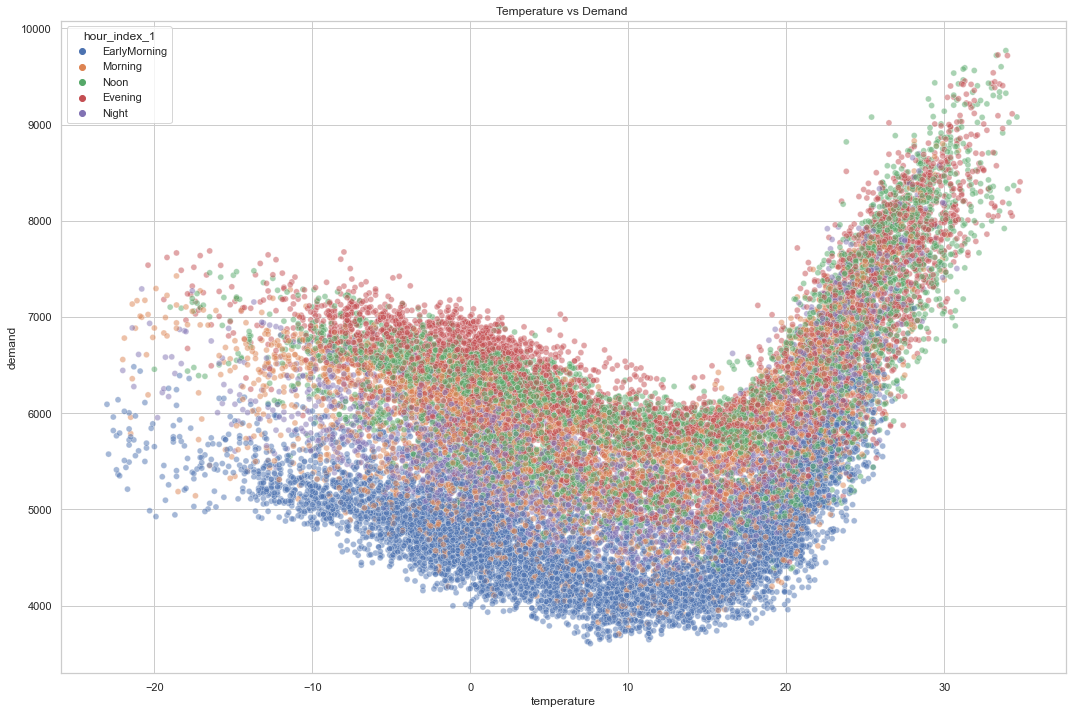

In [47]:
sns.scatterplot(x='temperature',y='demand',hue='hour_index_1',data=data, alpha = 0.5);
plt.title('Temperature vs Demand ');

This plot shows, how for each of the categorythe temperature dision makes it linear in each of them

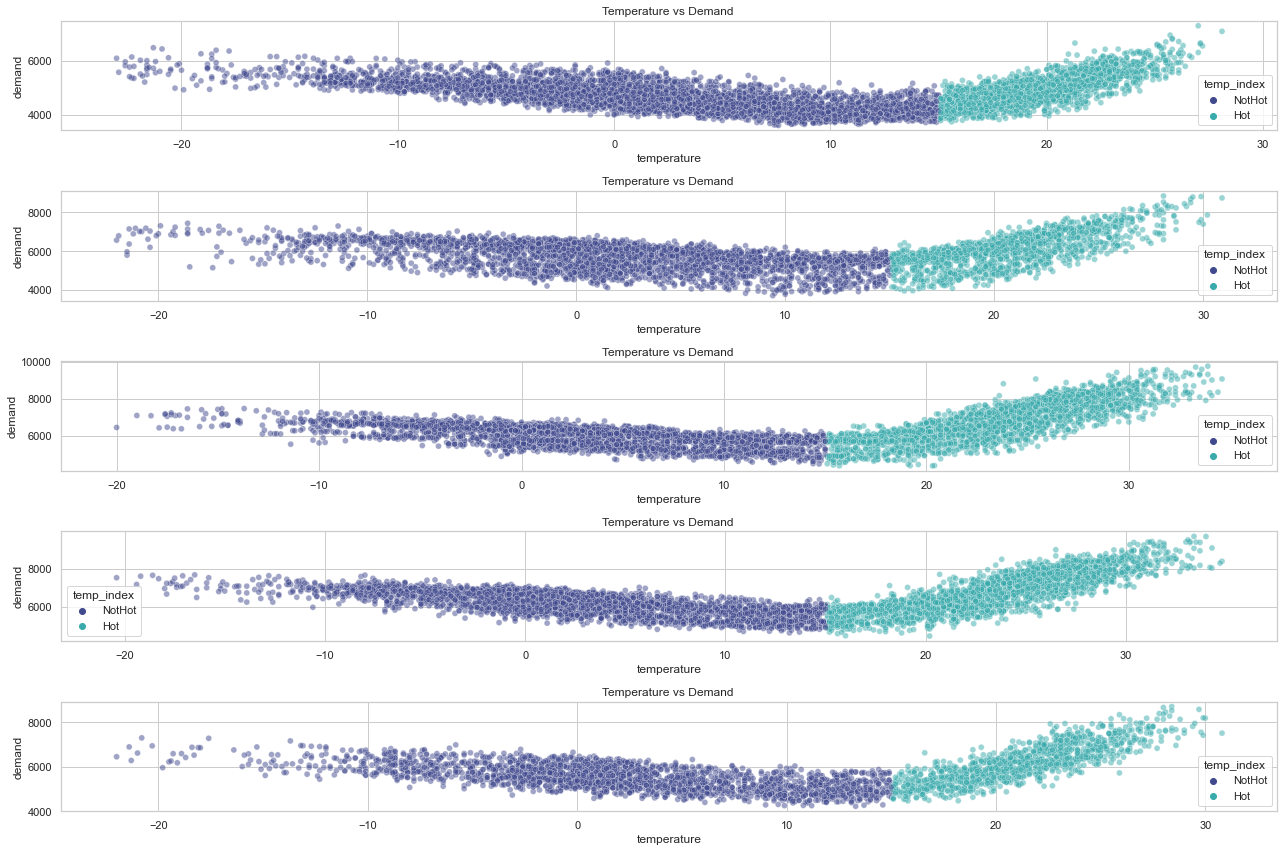

In [48]:
fig, axes = plt.subplots(nrows=5, ncols=1)

sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "EarlyMorning"'),hue='temp_index',ax=axes[0],palette="mako", alpha = 0.5);
axes[0].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Morning"'),hue='temp_index',ax=axes[1],palette="mako", alpha = 0.5);
axes[1].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Noon"'),hue='temp_index',ax=axes[2],palette="mako", alpha = 0.5);
axes[2].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Evening"'),hue='temp_index',ax=axes[3],palette="mako", alpha = 0.5);
axes[3].set_title('Temperature vs Demand ');
sns.scatterplot(x='temperature',y='demand',data=data.query('hour_index_1 == "Night"'),hue='temp_index',ax=axes[4],palette="mako", alpha = 0.5);
axes[4].set_title('Temperature vs Demand ');

fig.tight_layout()

In [49]:
pred_start = datetime.datetime.strftime(data.reset_index()['timestamp'].iloc[-1],'%Y-%m-%d')
train_end = datetime.datetime.strftime(data.reset_index()['timestamp'].iloc[-1],'%Y-%m-%d')[:8] + str(int(datetime.datetime.strftime(data.reset_index()['timestamp'].iloc[-1],'%Y-%m-%d')[8:])-1)
pred_day = data.loc[pred_start:]
train_days = data.loc['2017':train_end]

groupby_list = list(data.groupby(['temp_index','hour_index_1','week_index']).groups.keys())

The regression coefficient for each of the category is displayed below

In [50]:
start = time.time()

ridge_coef_2 = train_days.groupby(['temp_index','hour_index_1','week_index']).apply(Ridge_model)
display(pd.DataFrame(ridge_coef_2,columns=['Regression Coefficients (Intercept,Slope)']))

end = time.time()
time_lm20 = end - start
print(time_lm20)

Regression Coefficients (Intercept,Slope)
temp_index hour_index_1 week_index                                          
Hot        EarlyMorning Weekday                          (1908.208, 157.127)
                        Weekend                          (1361.379, 171.515)
           Evening      Weekday                          (2339.211, 199.157)
                        Weekend                          (1668.089, 198.797)
           Morning      Weekday                          (2396.549, 190.159)
                        Weekend                          (1098.132, 205.153)
           Night        Weekday                          (1505.823, 225.357)
                        Weekend                           (1440.29, 207.168)
           Noon         Weekday                          (2332.475, 199.373)
                        Weekend                           (1398.747, 204.39)
NotHot     EarlyMorning Weekday                            (4811.024, -49.1)
                        Weekend                          (4537.214, -48.451)
           Evening      Weekday                           (6488.81, -62.469)
                        Weekend                          (5969.887, -64.573)
           Morning      Weekday                           (6028.12, -50.682)
                        Weekend                          (5112.808, -50.184)
           Night        Weekday                           (5715.75, -48.768)
                        Weekend                          (5365.248, -50.093)
           Noon         Weekday                          (6351.394, -53.169)
                        Weekend                          (5702.294, -53.795)

0.05161619186401367


In [51]:
num = data['temp_index'].nunique()*data['hour_index_1'].nunique()*data['week_index'].nunique()

Train_error = np.zeros((num,1))

for i in range(1,num+1):
    train = train_days.groupby(['temp_index','hour_index_1','week_index']).apply(Ridge_error)[i-1]
    Train_error[i-1] = train
    
print(Train_error.mean())

354.3648


In [52]:
demand_hat_2 = []
for i in range(pred_day.shape[0]):
    demand_hat_2.append(predict(pred_day.iloc[i],['temp_index','hour_index_1','week_index'],ridge_coef_2))
print(f"The RMSE is: {RMSE_error(pred_day['demand'],demand_hat_2)}")

The RMSE is: 209.68908586466875


In [53]:
display(RMSE_error(pred_day['demand'],demand_hat_2)*100/pred_day['demand'].mean())

3.4193780690950693

In [54]:
prediction_interval_2 = []
for i in range(pred_day.shape[0]):
    prediction_interval_2.append(pred_interval(demand_hat_2[i],pred_day,demand_hat_2))
pred_int_2 = pd.DataFrame(prediction_interval_2,columns=['Lower','Actual','Upper'])
display(pred_int_2.head())

Lower    Actual        Upper
0  4779.476198  5208.734  5637.991802
1  4769.656198  5198.914  5628.171802
2  4774.566198  5203.824  5633.081802
3  4784.386198  5213.644  5642.901802
4  4808.936198  5238.194  5667.451802

In [55]:
df_2 = pd.DataFrame({'time':pred_day.index,'predictions':demand_hat_2})

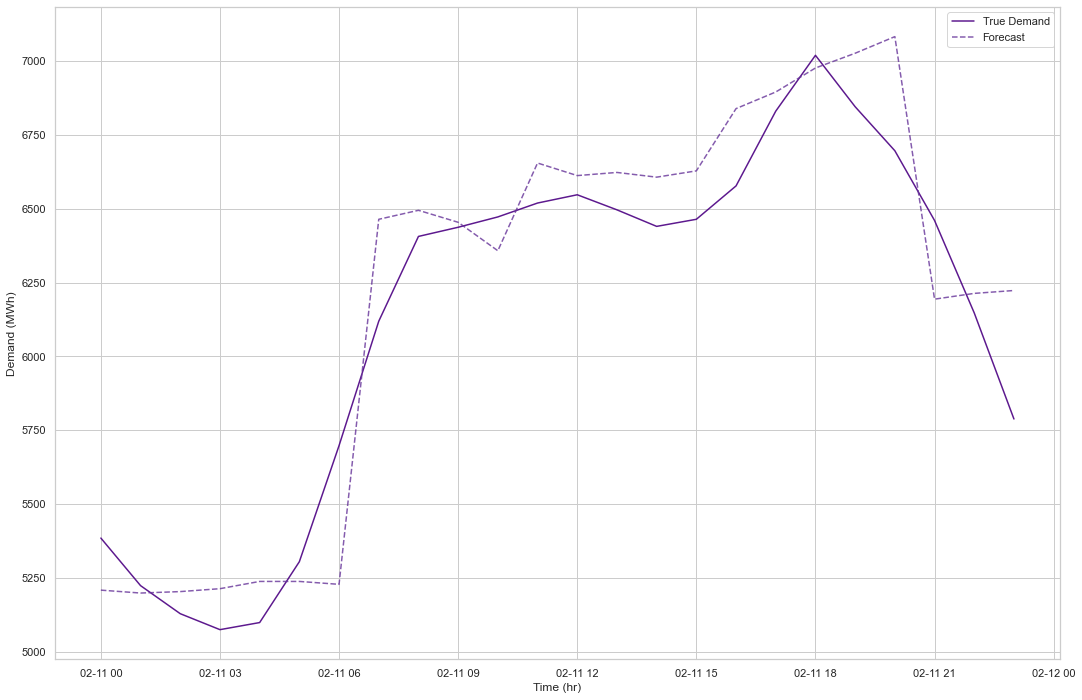

In [56]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df_2,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

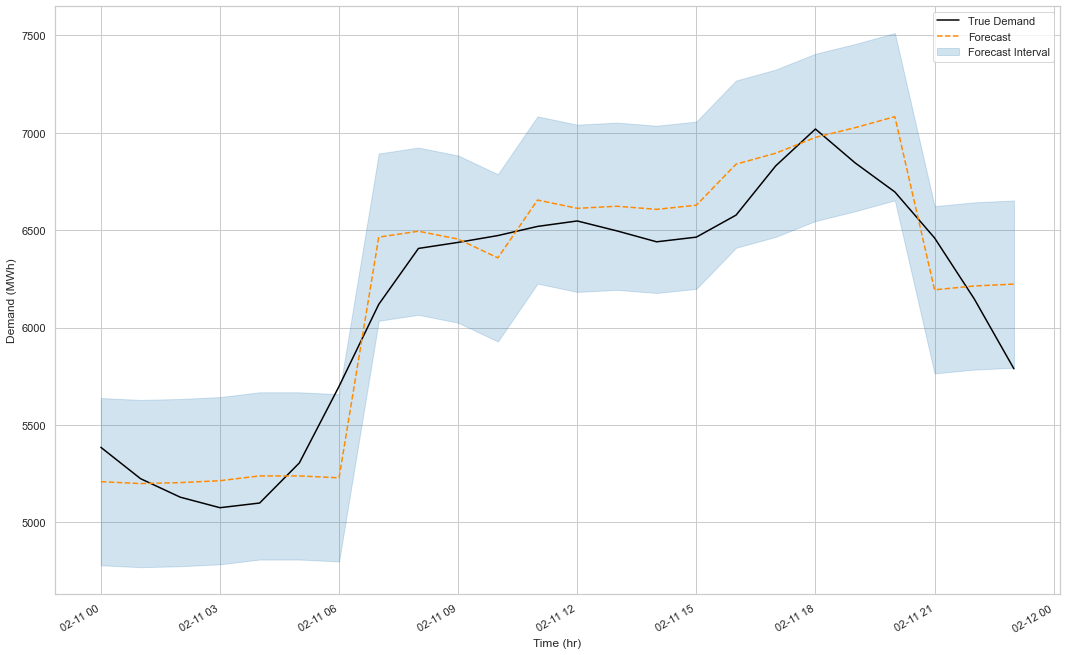

In [57]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_2.set_index(pred_day.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int_2['Lower'],pred_int_2['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

### Model with 24 categories 
#### One for each hour of the day
Here, we train a linear model with 24 categories. Therefore, we would have 2$*$2$*$24 = 96 sections. Therefore, we end up with 96 ridge regression models.

In [58]:
groupby_list = list(data.groupby(['temp_index','hour','week_index']).groups.keys())

In [59]:
start = time.time()

ridge_coef_3 = train_days.groupby(['temp_index','hour','week_index']).apply(Ridge_model)
display(pd.DataFrame(ridge_coef_3,columns=['Regression Coefficients (Intercept,Slope)']))

end = time.time()
time_lm96 = end - start
print(time_lm96)

Regression Coefficients (Intercept,Slope)
temp_index hour week_index                                          
Hot        0    Weekday                          (1580.552, 185.867)
                Weekend                          (1521.908, 182.274)
           1    Weekday                          (1678.998, 169.305)
                Weekend                          (1440.411, 174.582)
           2    Weekday                          (1704.068, 159.699)
...                                                              ...
NotHot     21   Weekend                          (5660.916, -52.351)
           22   Weekday                          (5732.045, -49.376)
                Weekend                          (5379.769, -49.866)
           23   Weekday                          (5313.553, -48.909)
                Weekend                          (5065.716, -49.909)

[96 rows x 1 columns]

0.12356305122375488


In [60]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(ridge_coef_3, columns=['Coefficients']))

                                   Coefficients
temp_index hour week_index                     
Hot        0    Weekday     (1580.552, 185.867)
                Weekend     (1521.908, 182.274)
           1    Weekday     (1678.998, 169.305)
                Weekend     (1440.411, 174.582)
           2    Weekday     (1704.068, 159.699)
                Weekend     (1506.896, 163.166)
           3    Weekday     (1874.661, 146.804)
                Weekend      (1449.854, 158.69)
           4    Weekday     (2103.878, 135.866)
                Weekend     (1645.944, 146.526)
           5    Weekday     (2357.585, 131.853)
                Weekend     (1665.077, 146.831)
           6    Weekday      (2737.314, 131.82)
                Weekend     (1840.094, 141.983)
           7    Weekday     (3028.231, 142.711)
                Weekend     (1723.157, 157.161)
           8    Weekday     (2962.611, 161.115)
                Weekend      (1426.374, 183.96)
           9    Weekday     (2693.783, 1

The mean count is: 284.25
The min count is: 77
The max count is: 593


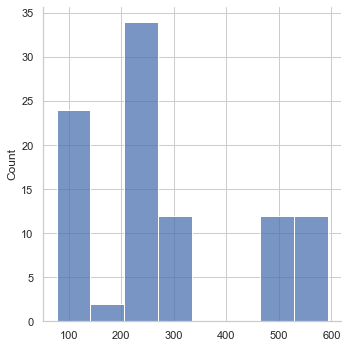

In [61]:
count_group = np.array(train_days.groupby(['temp_index','hour','week_index'])['demand'].count())
print(f"The mean count is: {count_group.mean()}")
print(f"The min count is: {count_group.min()}")
print(f"The max count is: {count_group.max()}")
sns.displot(count_group);

In [62]:
num = data['temp_index'].nunique()*data['hour'].nunique()*data['week_index'].nunique()

Train_error = np.zeros((num,1))

for i in range(1,num+1):
    train = train_days.groupby(['temp_index','hour','week_index']).apply(Ridge_error)[i-1]
    Train_error[i-1] = train

print(Train_error.mean())

296.4388645833333


In [63]:
demand_hat_3 = []
for i in range(pred_day.shape[0]):
    demand_hat_3.append(predict(pred_day.iloc[i],['temp_index','hour','week_index'],ridge_coef_3))
print(f"The RMSE is: {RMSE_error(pred_day['demand'],demand_hat_3)}")

The RMSE is: 121.31955337451967


In [64]:
display(RMSE_error(pred_day['demand'],demand_hat_3)*100/pred_day['demand'].mean())

1.978345312778812

In [65]:
prediction_interval_3 = []
for i in range(pred_day.shape[0]):
    prediction_interval_3.append(pred_interval(demand_hat_3[i],pred_day,demand_hat_3))
pred_int_3 = pd.DataFrame(prediction_interval_3,columns=['Lower','Actual','Upper'])
display(pred_int_3.head())

Lower     Actual        Upper
0  5109.652848  5358.0080  5606.363152
1  4893.409348  5141.7645  5390.119652
2  4774.214848  5022.5700  5270.925152
3  4735.400248  4983.7554  5232.110552
4  4794.972848  5043.3280  5291.683152

In [66]:
df_3 = pd.DataFrame({'time':pred_day.index,'predictions':demand_hat_3})

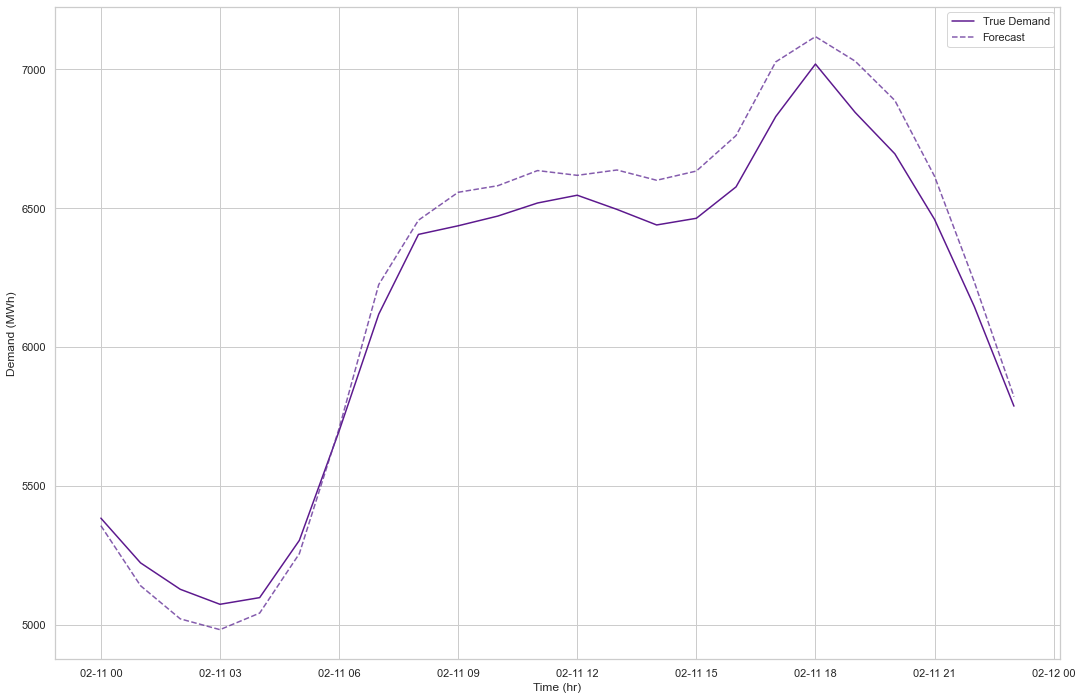

In [67]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df_3,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

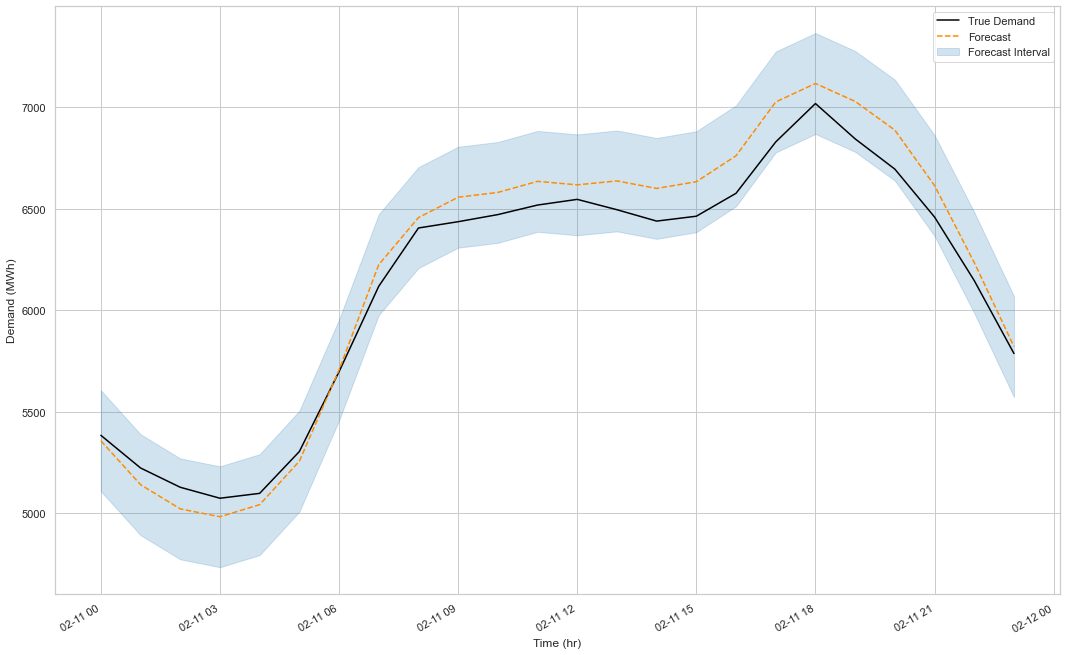

In [68]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_3.set_index(pred_day.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int_3['Lower'],pred_int_3['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

### Bonus Model: Polynomial regression deg 2

In [69]:
def Ridge_error_deg2(data):
    """
    Based on the provided data, this function returns the training error while performing ridge regression
    """
    data = data.sample(frac=1,random_state=42)
    x = data['temperature'].values.reshape(-1,1)
    y = data['demand'].values.reshape(-1,1)
    model = Ridge().fit(x,y)
    train_error = np.sqrt((1/y.shape[0])*np.sum(np.square(np.squeeze(model.predict(x)) - y.T)))
    return (round(float(train_error),3))

def Ridge_model_deg2(data):
    """
    Based on the provided data, this function returns the 
    coefficients of the ridge regression.
    
    input: the training data
    output: ridge regression coefficients
    
    """
    data = data.sample(frac=1,random_state=42)
    x = data['temperature'].values.reshape(-1,1)
    y = data['demand'].values.reshape(-1,1)
    poly = PolynomialFeatures(degree=2)
    x_ = poly.fit_transform(x)
    model = Ridge().fit(x_, y)
    return (model.intercept_,model.coef_)

def predict_deg2(data,group_by,ridge_coef):
    """
    Given, a data point, the groups by which we split and the regression coefficients, this function returns a prediction
    """
    group = tuple(data[group_by])
    idx = groupby_list.index(group)
    inter,coef = ridge_coef[idx]
    x = data['temperature']
    return float(inter) + float(coef[0,0]*(x**0)) + float(coef[0,1]*(x**1)) + float(coef[0,2]*(x**2))

In [70]:
start = time.time()

ridge_coef_4 = train_days.groupby(['temp_index','hour','week_index']).apply(Ridge_model_deg2)
display(pd.DataFrame(ridge_coef_4,columns=['Regression Coefficients (Intercept,Slope)']))

end = time.time()
time_pm96 = end - start
print(time_pm96)

Regression Coefficients (Intercept,Slope)
temp_index hour week_index                                                   
Hot        0    Weekday     ([3295.544375829493], [[0.0, 14.60458302328393...
                Weekend     ([3294.6002921096747], [[0.0, 4.77578433704255...
           1    Weekday     ([3519.2719977956203], [[0.0, -16.929422890229...
                Weekend     ([4489.251108829245], [[0.0, -135.539697551666...
           2    Weekday     ([3671.7559076888783], [[0.0, -41.182184703169...
...                                                                       ...
NotHot     21   Weekend     ([5662.869398815462], [[0.0, -52.229367863118,...
           22   Weekday     ([5709.70965225338], [[0.0, -50.41101671719136...
                Weekend     ([5376.725997011634], [[0.0, -50.0297232091221...
           23   Weekday     ([5296.302227015581], [[0.0, -49.6058776246498...
                Weekend     ([5062.1234860519435], [[0.0, -50.062354026265...

[96 rows x 1 columns]

0.15874814987182617


In [71]:
demand_hat_4 = []
for i in range(pred_day.shape[0]):
    demand_hat_4.append(predict_deg2(pred_day.iloc[i],['temp_index','hour','week_index'],ridge_coef_4))
print(f"The RMSE is: {RMSE_error(pred_day['demand'],demand_hat_4)}")

The RMSE is: 123.71169847519243


In [72]:
prediction_interval_4 = []
for i in range(pred_day.shape[0]):
    prediction_interval_4.append(pred_interval(demand_hat_4[i],pred_day,demand_hat_4))
pred_int_4 = pd.DataFrame(prediction_interval_4,columns=['Lower','Actual','Upper'])
display(pred_int_4.head())

Lower       Actual        Upper
0  5109.718884  5362.971034  5616.223184
1  4893.843578  5147.095728  5400.347878
2  4776.587107  5029.839257  5283.091407
3  4739.161899  4992.414049  5245.666199
4  4798.422177  5051.674327  5304.926477

In [73]:
df_4 = pd.DataFrame({'time':pred_day.index,'predictions':demand_hat_4})

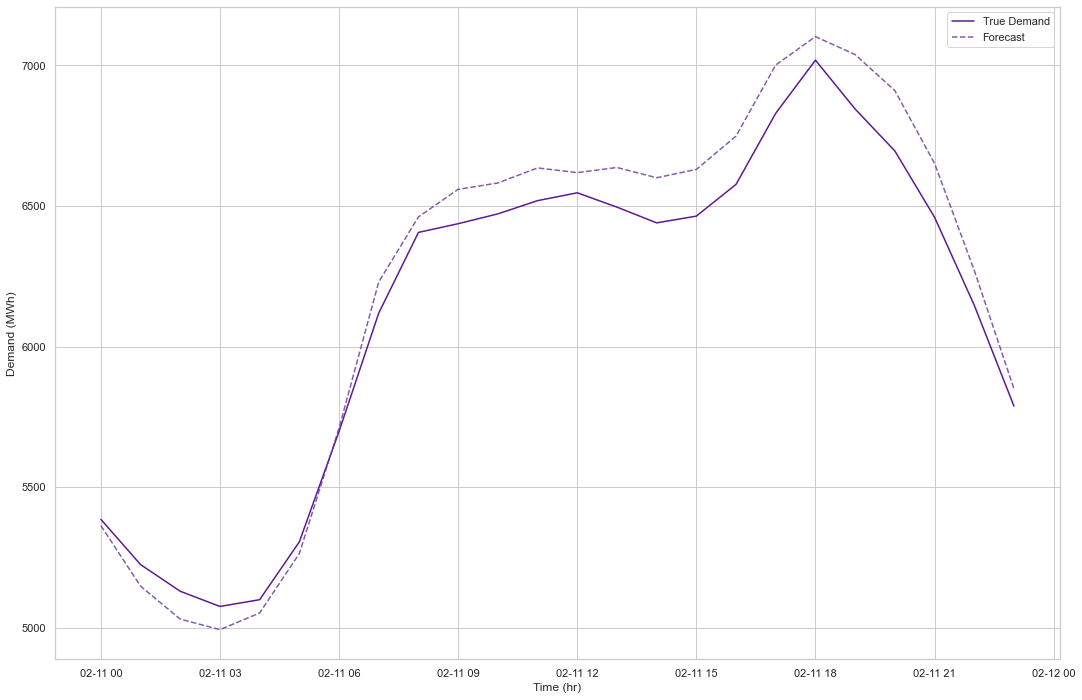

In [74]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="indigo",alpha=0.9);
sns.lineplot(x = 'time', y = 'predictions', data = df_4,label='Forecast', color="rebeccapurple",linestyle='dashed',alpha=0.8);
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

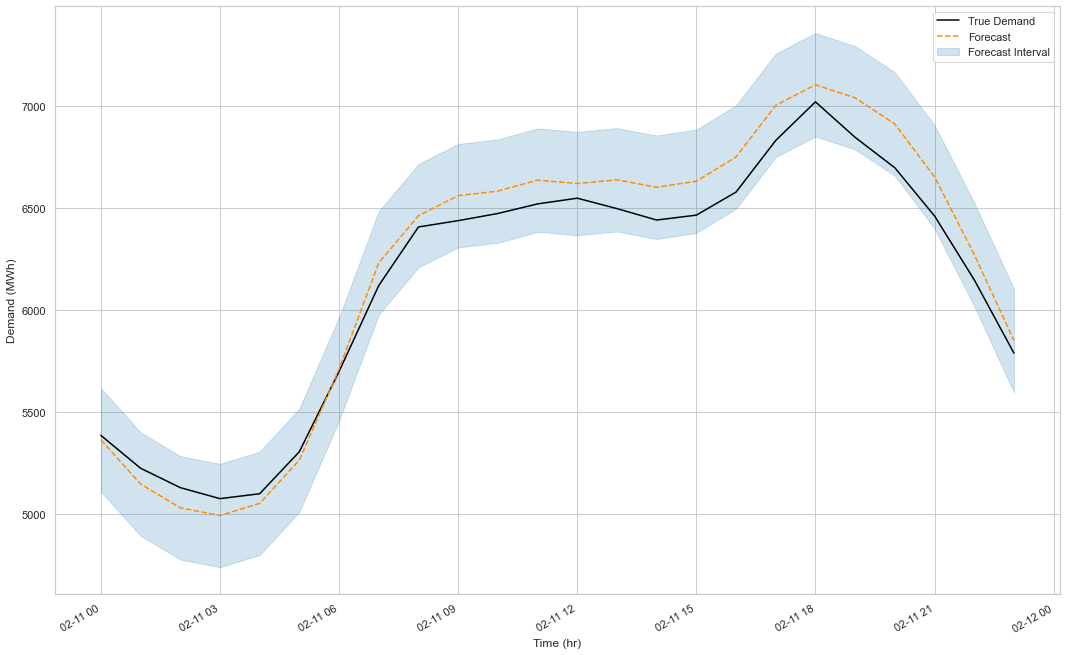

In [75]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_4.set_index(pred_day.index).reset_index(),label='Forecast',color="darkorange",linestyle='dashed')
plt.fill_between(df['time'],pred_int_4['Lower'],pred_int_4['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

In [76]:
RMSE = [RMSE_error(pred_day['demand'],demand_hat),RMSE_error(pred_day['demand'],demand_hat_0),RMSE_error(pred_day['demand'],demand_hat_1),RMSE_error(pred_day['demand'],demand_hat_2),RMSE_error(pred_day['demand'],demand_hat_3),RMSE_error(pred_day['demand'],demand_hat_4)]
percent = [RMSE_error(pred_day['demand'],demand_hat)*100/pred_day['demand'].mean(),RMSE_error(pred_day['demand'],demand_hat_0)*100/pred_day['demand'].mean(),RMSE_error(pred_day['demand'],demand_hat_1)*100/pred_day['demand'].mean(),RMSE_error(pred_day['demand'],demand_hat_2)*100/pred_day['demand'].mean(),RMSE_error(pred_day['demand'],demand_hat_3)*100/pred_day['demand'].mean(),RMSE_error(pred_day['demand'],demand_hat_4)*100/pred_day['demand'].mean()]
comp = ['N/A','N/A',time_lm8,time_lm20,time_lm96,time_pm96]
Model = ['Baseline Model','Baseline Model II','Linear (8)','Linear (20)','Linear (96)', 'Quadratic (96)']
display(pd.DataFrame({'Model':Model,'RMSE (MWh)':RMSE,'Percent Error (%)':percent,'Comp Time (sec)':comp}))

Model   RMSE (MWh)  Percent Error (%) Comp Time (sec)
0     Baseline Model  1195.021583          19.487092             N/A
1  Baseline Model II   711.313896          11.599322             N/A
2         Linear (8)   265.615399           4.331363        0.046865
3        Linear (20)   209.689086           3.419378       0.0516162
4        Linear (96)   121.319553           1.978345        0.123563
5     Quadratic (96)   123.711698           2.017354        0.158748

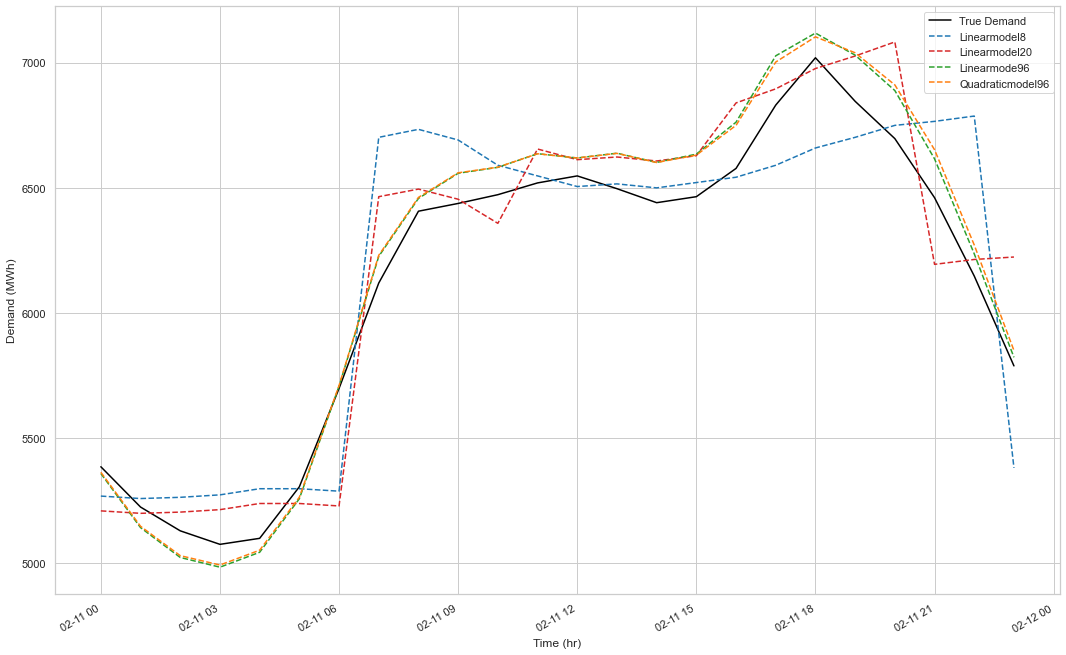

In [77]:
sns.lineplot(x = 'timestamp', y = 'demand', data = pred_day.reset_index(), label='True Demand',color="black");
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_1.set_index(pred_day.index).reset_index(),label='Linearmodel8',color="tab:blue",linestyle='dashed')
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_2.set_index(pred_day.index).reset_index(),label='Linearmodel20',color="tab:red",linestyle='dashed')
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_3.set_index(pred_day.index).reset_index(),label='Linearmode96',color="tab:green",linestyle='dashed')
sns.lineplot(x = 'timestamp', y = 'Actual',  data = pred_int_4.set_index(pred_day.index).reset_index(),label='Quadraticmodel96',color="tab:orange",linestyle='dashed')
plt.gcf().autofmt_xdate(); # To tilt and rotate the xaxis labels
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');

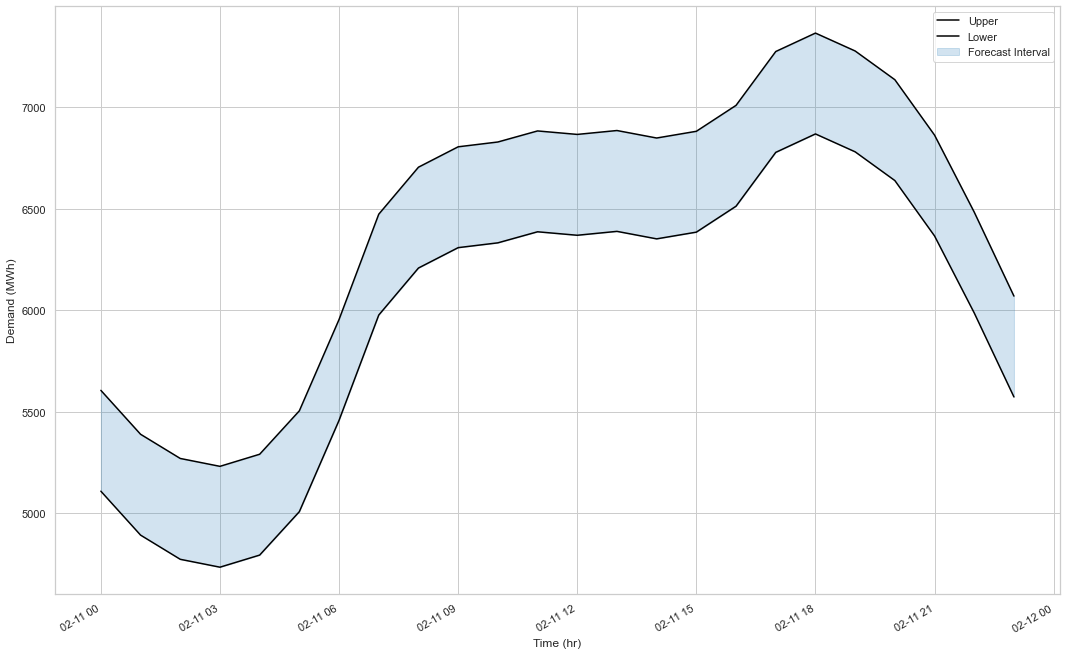

In [78]:
plt.plot(df['time'], pred_int_3['Upper'], label='Upper',color="black");
plt.plot(df['time'], pred_int_3['Lower'],label='Lower',color="black")
plt.fill_between(df['time'],pred_int_3['Lower'],pred_int_3['Upper'],label='Forecast Interval',color="tab:blue",alpha=0.2);
plt.gcf().autofmt_xdate();
plt.legend();
plt.xlabel('Time (hr)');
plt.ylabel('Demand (MWh)');